# Doc2Vec Process

We divide this process into three steps:

- **Doc2Vec Model Trainng**: Using contracts, we train a doc2vec model to turn contract sentences into representations.

- **Processing a New Contract**: Given the doc2vec model, we start the process in a new contract.

    - Norm Extraction: First, we extract the norms from the new contract;
    - Then, we create a representation for each norm using the doc2vec model.
    
- **Conflict Identification**: Using the norm representations, we can have two different paths to follow:

    - T-SNE: Manual identification of modal verbs. (Experimental)
    - Norm Comparisons: Compare norms and find the most similar among them based on a threshold.

### Doc2Vec Model Training

In [1]:
# -*- coding:utf-8 -*-
import os
import sys
import pickle
import argparse
import logging
from random import shuffle
from convert_to_sentences import convert_to_sentences
from time import gmtime, strftime
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sentence_classifier.sentence_classifier import SentenceClassifier

Using TensorFlow backend.
/home/aires/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
# CONSTANTS.
MODEL_BASE_NAME = 'models/model_2017-12-04_19-50-36'
TRAIN = False
TRAIN_PATH = 'dataset/manufact_cntrcs.txt'
PREPROCESS = False
TEST = True
TEST_PATH = MODEL_BASE_NAME + '.doc2vec'
MODEL = False
MODEL_PATH = 'model_2017-11-27_18-21-45.doc2vec'

In [3]:
# Set argparse.
parser = argparse.ArgumentParser(description='Convert sentences and paragraphs into a dense representation.')

# Set logger.
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s:%(levelname)s:%(message)s')

file_handler = logging.FileHandler('logs/doc2vec.log')
file_handler.setFormatter(formatter)

logger.addHandler(file_handler)

In [4]:
# Set sentence classifier.
sent_cls_path = 'sentence_classifier/classifiers/17-11-03_18:45/sentence_classifier_17-11-03_18:45.pkl'
sent_cls_names_path = 'sentence_classifier/classifiers/17-11-03_18:45/sentence_classifier_dict_17-11-03_18:45.pkl'
sent_cls = SentenceClassifier()
sent_cls.load_classifier(sent_cls_path)
sent_cls_names = pickle.load(open(sent_cls_names_path, 'r'))
sent_cls.set_names(sent_cls_names)

In [5]:
class LabeledLineSentence(object):
    def __init__(self, filename):
        self.filename = filename
        self.sentences = []
        self.vocab = dict()

    def __iter__(self):
        for uid, line in enumerate(open(self.filename)):
            for token in line.split():
                if token not in self.vocab:
                    self.vocab[token] = True
            yield TaggedDocument(words=line.split(), tags=['SENT_%s' % uid])

    def sentences_perm(self):
        shuffle(self.sentences)
        return self.sentences
    
    def save_vocab(self):
        pickle.dump(self.vocab, open('vocab.pkl', 'w'))

In [6]:
def get_model_path():

    logger.info('Generating output path.')
    if not os.path.isdir('models'):
        os.makedirs('models')

    return 'models/model_' + strftime("%Y-%m-%d_%H-%M-%S.doc2vec", gmtime())

In [7]:
def train_model(sentences, model=None):
    logger.info('Training model.')

    if not model:
        model = Doc2Vec(size=100, window=2, min_count=2, workers=2, alpha=0.025, min_alpha=0.025)

    model.build_vocab(sentences)
    
    for epoch in range(10):
        model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)
        model.alpha -= 0.002  # decrease the learning rate
        model.min_alpha = model.alpha  # fix the learning rate, no decay

    output_path = get_model_path()

    logger.info('Saving trained model.')
    model.save(output_path)

    return output_path

In [8]:
def create_sent_dict(sentences):

    s_dict = dict()

    for sent in sentences:
        s_dict[sent[1][0]] = sent[0]

    return s_dict

In [15]:
if TRAIN:

    file_path = TRAIN_PATH

    logger.info('Receive training path: %s' % file_path)

    # Get sentences.
    if PREPROCESS:
        logger.info('Preprocessing file.')
        file_path = convert_to_sentences(file_path)

    sentences = LabeledLineSentence(file_path)
    
    sentences.save_vocab()
    
    # Create a dict to convert a sent code into its respective sentence.
    sent_dict = create_sent_dict(sentences)

    if not MODEL:
        model = train_model(sentences)
    else:
        old_model = Doc2Vec.load(MODEL_PATH)
        model = train_model(sentences, old_model)

    base, _ = os.path.splitext(model)

    # Save the dict.
    pickle.dump(sent_dict, open(base + '.pkl', 'w'))

elif TEST:
    model = Doc2Vec.load(TEST_PATH)
    sent_dict = pickle.load(open(MODEL_BASE_NAME + '.pkl', 'r'))
    
else:
    print "Nothing to do here."

### Processing a new contract

In [16]:
import pickle
import numpy as np
from nltk.tokenize import sent_tokenize

In [17]:
model.infer_vector('must')

array([ 0.06790036,  0.04055977, -0.0684411 ,  0.03933974, -0.03659917,
       -0.02640558,  0.02619336,  0.04344094,  0.0493461 , -0.04965301,
       -0.01697304, -0.01788192, -0.0027094 , -0.05245531, -0.03431024,
        0.02956641,  0.00694542,  0.03583742,  0.13673346,  0.00476387,
        0.09217563,  0.08370192, -0.07268881, -0.11788809, -0.09000862,
        0.03240034, -0.01577382,  0.01591088,  0.00127688, -0.10395204,
        0.00220732,  0.14119275,  0.09290379,  0.05786966,  0.02603045,
        0.0099138 , -0.0409131 , -0.02562972, -0.05184904, -0.02904597,
        0.0485239 ,  0.15066943,  0.02394779, -0.07068499, -0.03604756,
        0.07881876, -0.05150216,  0.03845914,  0.03692538, -0.02614806,
        0.08093952, -0.03397892, -0.08648488, -0.01480197,  0.09660164,
       -0.12012898, -0.09753798,  0.06718577,  0.03404033, -0.03653711,
        0.06166851,  0.038797  , -0.07138322, -0.02902924, -0.06312327,
        0.01926978,  0.00876452,  0.05563311, -0.05131899,  0.01

In [18]:
contract_path = 'dataset/lease_contract.txt'

In [19]:
def extract_norms(sentences, path_to_classifier):    
    # Load sentence classifier.
    norms = []
    
    for sent in sentences:
        
        pred = sent_cls.predict_class([sent])
        
        if pred[0]:
            norms.append(sent)
    
    return norms

In [20]:
# Read contract text.
text = open(contract_path, 'r').read().decode('utf-8')
logger.info("Text extracted: {}".format(text[:100]))

# Extract sentences.
sentences = sent_tokenize(text)
logger.info("Sentences extracted: {}".format(sentences[:5]))

# Extract Norms.
norms = extract_norms(sentences, sent_cls_path)
logger.info("Norms extracted: {}".format(norms[:2]))

# Get norm representations.
norm_representations = np.zeros(shape=(len(norms), 100))
norm_text = dict()

for i, norm in enumerate(norms):
    norm_text[i] = norm
    norm_representations[i] = model.infer_vector(norm)

### Conflict Identification

We divide this section into two subsections: T-SNE and Norm Representation Comparison

##### T-SNE

In [21]:
from  matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
# Get vocabulary.
vocab = pickle.load(open('vocab.pkl', 'r'))
words = []
reps = []

for k in vocab:
    words.append(k)
    reps.append(model.infer_vector(k))

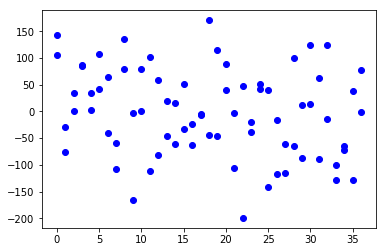

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [22]:
X_tsne = TSNE(n_components=2).fit_transform(norm_representations)
plt.plot(X_tsne, 'bo')
plt.show(X_tsne)

##### Norm Representation Comparison

In [23]:
threshold = 0.3

In [24]:
def find_similars(indx, norm_rep, norm_representations):

    sub = np.subtract(norm_rep, norm_representations)
    absl = np.absolute(sub)
    summ = absl.sum(axis=1)
    max_val = np.max(summ)
    diff = np.divide(summ, max_val)
    
    similar = np.where(diff < threshold)[0]
    percents = []
    for i in similar:
        percents.append(diff[i])
        
    return similar, percents

In [25]:
# Run over norm representations.
similars = dict()
for ind, norm_rep in enumerate(norm_representations):
    
    similars[ind] = find_similars(ind, norm_rep, norm_representations)
    if similars[ind]:
        if float(similars[ind][1][0]) > 0.0:
            print "Original: %s \n\n Potential Conflict: %s\n Percentage: %.2f\n\n-----------------------------------------" % (norm_text[ind], norm_text[similars[ind][0][0]], similars[ind][1][0])

Original: INSPECTION

7.1 The LESSEE hereby authorizes the LESSOR to examine or inspect the rented Property, on a day and at a time previously agreed upon with the LESSEE. 

 Potential Conflict: 2.2 The Parties establish that the LESSEE may return the Property before the end of the lease term, without incurring any penalty and/or fine at any time.
 Percentage: 0.28

-----------------------------------------
Original: In case LESSOR fails to do so, it shall exempt the GUARANTOR from any liability with respect to the suretyship. 

 Potential Conflict: 2.2 The Parties establish that the LESSEE may return the Property before the end of the lease term, without incurring any penalty and/or fine at any time.
 Percentage: 0.29

-----------------------------------------
Original: APPLICABLE LEGISLATION

17.1    Any cases not expressly covered herein shall be governed by Act no. 

 Potential Conflict: For such purpose, the LESSEE shall notify the LESSOR in writing at least ten (10) days before t